In [2]:
name = "Diogo José Costa Alves"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)


Name:  Diogo José Costa Alves

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



# MAC0460 / MAC5832 (2022)
<hr>

# EP2: Linear regression - analytic solution

### Objectives:

- to implement and test the analytic solution for the linear regression task (see, for instance, <a href="http://work.caltech.edu/slides/slides03.pdf">Slides of Lecture 03</a> of *Learning from Data*)
- to understand the core idea (*optimization of a loss or cost function*) for parameter adjustment in machine learning

### What to do:
- some cells of this notebook must be filled. Places to be filled are indicated as:

<code>
    # START OF YOUR CODE:
    
    # END OF YOUR CODE
</code> 
<hr>

# Linear regression

Given a dataset $\{(\mathbf{x}^{(1)}, y^{(1)}), \dots ,(\mathbf{x}^{(N)}, y^{(N)})\}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$ and $y^{(i)} \in \mathbb{R}$, we would like to approximate the unknown function $f:\mathbb{R}^{d} \rightarrow \mathbb{R}$ (recall that $y^{(i)} =f(\mathbf{x}^{(i)})$) by means of a linear model $h$:
$$
h(\mathbf{x}^{(i)}; \mathbf{w}, b) = \mathbf{w}^\top  \mathbf{x}^{(i)} + b
$$

Note that $h(\mathbf{x}^{(i)}; \mathbf{w}, b)$ is, in fact, an  [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) of  $\mathbf{x}^{(i)}$. As commonly done, we will use the term "linear" to refer to an affine transformation.

The output of $h$ is a linear transformation of $\mathbf{x}^{(i)}$. We use the notation $h(\mathbf{x}^{(i)}; \mathbf{w}, b)$ to make clear that $h$ is a parametric model, i.e., the transformation $h$ is defined  by the parameters $\mathbf{w}$ and $b$. We can view vector $\mathbf{w}$ as a *weight* vector that controls the effect of each *feature* in the prediction.

By adding one component with value equal to 1 to the observations $\mathbf{x}$ (an artificial coordinate), we have:

$$\tilde{\mathbf{x}} = (1, x_1, \ldots, x_d) \in \mathbb{R}^{1+d}$$

and then we can simplify the notation:
$$
h(\mathbf{x}^{(i)}; \mathbf{w}) = \hat{y}^{(i)} = \mathbf{w}^\top  \tilde{\mathbf{x}}^{(i)}
$$

We would like to determine the optimal parameters $\mathbf{w}$ such that prediction $\hat{y}^{(i)}$ is as closest as possible to $y^{(i)}$ according to some error metric. Adopting the *mean square error* as such metric we have the following cost function:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

Thus, the task of determining a function $h$ that is closest to $f$ is reduced to the task of finding the values $\mathbf{w}$ that minimize $J(\mathbf{w})$.



## Some imports

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


%matplotlib inline

### Auxiliary functions
The two auxiliary functions below are for generating simulated data and for plotting data.

In [128]:
# An auxiliary function
# - Added trials variable only to understand how typical is the need to re-sampling
# - Added seed parameter to make data sampling more deterinistic
def get_housing_prices_data(N, verbose=True, seed=0):
    """
    Generates artificial linear data,
    where x = square meter, y = house price

    :param N: data set size
    :type N: int
    
    :param verbose: param to control print
    :type verbose: bool
    :return: design matrix, regression targets
    :rtype: np.array, np.array
    """
    np.random.seed(seed)
    cond = False
    trials = 0
    while not cond:
        x = np.linspace(90, 1200, N)
        gamma = np.random.normal(30, 10, x.size)
        y = 50 * x + gamma * 400
        x = x.astype("float32")
        x = x.reshape((x.shape[0], 1))
        y = y.astype("float32")
        y = y.reshape((y.shape[0], 1))
        cond = min(y) > 0
        trials = trials + 1
        
    xmean, xsdt, xmax, xmin = np.mean(x), np.std(x), np.max(x), np.min(x)
    ymean, ysdt, ymax, ymin = np.mean(y), np.std(y), np.max(y), np.min(y)
    if verbose:
        print("\nX shape = {}".format(x.shape))
        print("y shape = {}\n".format(y.shape))
        print("X: mean {}, sdt {:.2f}, max {:.2f}, min {:.2f}".format(xmean,
                                                               xsdt,
                                                               xmax,
                                                               xmin))
        print("y: mean {:.2f}, sdt {:.2f}, max {:.2f}, min {:.2f}".format(ymean,
                                                                 ysdt,
                                                                 ymax,
                                                                 ymin))

        print("\nTried ", str(trials), 'times.')
    return x, y

In [3]:
# Another auxiliary function
# - added mse input
def plot_points_regression(x,
                           y,
                           title,
                           xlabel,
                           ylabel,
                           prediction=None,
                           legend=False,
                           r_squared=None,
                           mse=None,
                           position=(90, 100)):
    """
    Plots the data points and the prediction,
    if there is one.

    :param x: design matrix
    :type x: np.array
    :param y: regression targets
    :type y: np.array
    :param title: plot's title
    :type title: str
    :param xlabel: x axis label
    :type xlabel: str
    :param ylabel: y axis label
    :type ylabel: str
    :param prediction: model's prediction
    :type prediction: np.array
    :param legend: param to control print legends
    :type legend: bool
    :param r_squared: r^2 value
    :type r_squared: float
    :param mse: mean squared error value
    :type mse: float    
    :param position: text position
    :type position: tuple
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    line1, = ax.plot(x, y, 'bo', label='Real data')
    if prediction is not None:
        line2, = ax.plot(x, prediction, 'r', label='Predicted data')
        if legend:
            plt.legend(handles=[line1, line2], loc=2)
        ax.set_title(title,
                 fontsize=20,
                 fontweight='bold')
    if r_squared is not None:
        bbox_props = dict(boxstyle="square,pad=0.3",
                          fc="white", ec="black", lw=0.2)
        t = ax.text(position[0], position[1], "$R^2 ={:.4f}$".format(r_squared),
                    size=15, bbox=bbox_props)

    if mse is not None:
        bbox_props = dict(boxstyle="square,pad=0.3",
                          fc="white", ec="black", lw=0.2)
        t = ax.text(position[0]+500, position[1], "$MSE ={:.2f}$".format(mse),
                    size=15, bbox=bbox_props)

    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    plt.show()


### The dataset and the task

The first dataset we will use is a toy dataset. We will generate $N=100$ observations with only one *feature* and a real value associated to each of them. We can view these observations as being pairs *(area of a real state in square meters, price of the real state)*. Our task is to construct a model that is able to predict the price of a real state, given its area.

In [129]:
X, y = get_housing_prices_data(N=100)


X shape = (100, 1)
y shape = (100, 1)

X: mean 645.0, sdt 323.65, max 1200.00, min 90.00
y: mean 44489.23, sdt 16337.17, max 78022.27, min 15393.92

Tried  1 times.


### Ploting the data

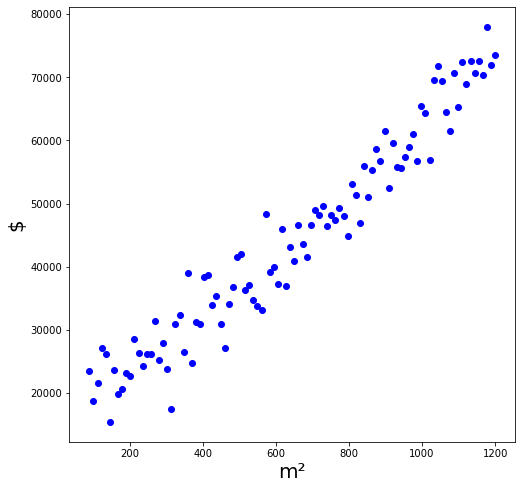

In [11]:
plot_points_regression(X,
                       y,
                       title='Real estate prices prediction',
                       xlabel="m\u00b2",
                       ylabel='$')

### The solution

Given $f:\mathbb{R}^{N\times M} \rightarrow \mathbb{R}$ and $\mathbf{A} \in \mathbb{R}^{N\times M}$, we define the gradient of $f$ with respect to $\mathbf{A}$ as:

$$
\nabla_{\mathbf{A}}f = \frac{\partial f}{\partial \mathbf{A}} =  \begin{bmatrix}
\frac{\partial f}{\partial \mathbf{A}_{1,1}} & \dots & \frac{\partial f}{\partial \mathbf{A}_{1,m}} \\
\vdots &  \ddots & \vdots \\
\frac{\partial f}{\partial \mathbf{A}_{n,1}} &  \dots & \frac{\partial f}{\partial \mathbf{A}_{n,m}}
\end{bmatrix}
$$

Let $\mathbf{X} \in \mathbb{R}^{N\times (1+d)}$ be a matrix (sometimes also called the *design matrix*) whose rows are the extended observations of the dataset and let $\mathbf{y} \in \mathbb{R}^{N}$ be the vector consisting of all values $y^{(i)}$ (i.e., $\mathbf{X}^{(i,:)} = \mathbf{\tilde{x}}^{(i)}$ and $\mathbf{y}^{(i)} = y^{(i)}$). It can be verified that: 

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}(\mathbf{X}\mathbf{w} - \mathbf{y})^{T}(\mathbf{X}\mathbf{w} - \mathbf{y})
\end{equation}

Using basic matrix derivative concepts we can compute the gradient of $J(\mathbf{w})$ with respect to $\mathbf{w}$:

\begin{equation}
\nabla_{\mathbf{w}}J(\mathbf{w}) = \frac{2}{N} (\mathbf{X}^{T}\mathbf{X}\mathbf{w} -\mathbf{X}^{T}\mathbf{y})   
\end{equation}

Thus, when $\nabla_{\mathbf{w}}J(\mathbf{w}) = 0$ we have 

\begin{equation}
\mathbf{X}^{T}\mathbf{X}\mathbf{w} = \mathbf{X}^{T}\mathbf{y}
\end{equation}

Hence,

\begin{equation}
\mathbf{w} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}
\end{equation}

Note that this solution has a high computational cost. As the number of variables (*features*) increases, the cost for matrix inversion becomes prohibitive. See  [this text](https://sgfin.github.io/files/notes/CS229_Lecture_Notes.pdf) for more details.

## NumPy
Quoted from [NumPy documentation](https://numpy.org/doc/stable/): "NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more."

A quick introduction to this library can be found [here](http://cs231n.github.io/python-numpy-tutorial/). Particularly useful for this EP (and this course) are the "array math" related tools.

# <mark>Exercise 1</mark>
The objective of this exercise is to apply the solution just described on the dataset above created.

Using only **NumPy**, complete the two functions below. Recall that $\mathbf{X} \in \mathbb{R}^{N\times d}$; thus you will need to add a component of value 1 to each of  the observations in $\mathbf{X}$ before performing the computation described above.

NOTE: Although the dataset above has data of dimension $d=1$, your code must be generic (it should work for $d\geq1$)

## <mark>1.1. Weight computation function</mark>

In [4]:
def normal_equation_weights(X, y):
    """
    Calculates the weights of a linear function using the normal equation method.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d, 1))
    """
    
    # START OF YOUR CODE:
    X = np.column_stack( [np.ones((X.shape[0],1)), X ]) # adds the bias term in X
    weights = np.dot( np.dot( np.linalg.pinv( np.dot(X.T, X) ), X.T), y) # normal method
    return weights
    # END OF YOUR CODE
    

In [14]:
# test of function normal_equation_weights()
# - added weights shape printing. this help me make sensen of dot products

w = normal_equation_weights(X, y)
print("Estimated w =\n", w)
print("Shape:", w.shape)

Estimated w =
 [[12930.31620366]
 [   48.92855189]]
Shape: (2, 1)


## <mark>1.2. Prediction function</mark>

In [5]:
def normal_equation_prediction(X, w):
    """
    Calculates the prediction over a set of observations X using the linear function
    characterized by the weight vector w.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param w: weight vector
    :type w: np.ndarray(shape=(1+d, 1))
    :param y: regression prediction
    :type y: np.ndarray(shape=(N, 1))
    """
    
    # START OF YOUR CODE:
    X = np.column_stack( [np.ones((X.shape[0],1)), X ]) # adds the bias term in X
    predicted = np.dot(X, w)
    return predicted
    # END OF YOUR CODE


## <mark>1.3. Coefficient of determination</mark>
We can use the [$R^2$](https://pt.wikipedia.org/wiki/R%C2%B2) metric (Coefficient of determination) to evaluate how well the linear model fits the data.

**Which $𝑅^2$ value would you expect to observe ?**

Answer: I expect a value in interval (0,5, 1)

16132973.378021726


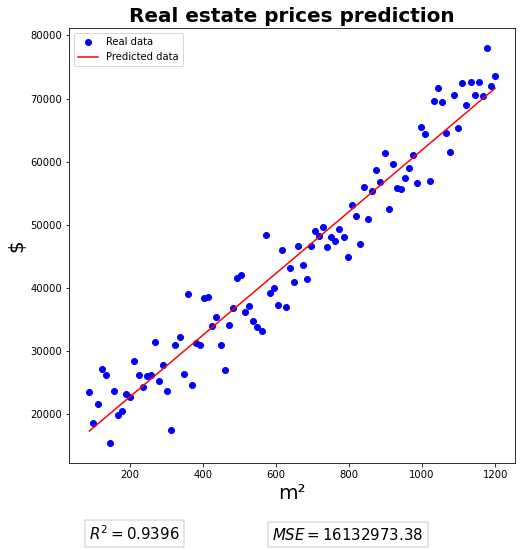

In [40]:
# test of function normal_equation_prediction()
prediction = normal_equation_prediction(X, w)

# compute the R2 score using the r2_score function from sklearn
# Replace 0 with an appropriate call of the function

# START OF YOUR CODE:
r_2 = r2_score(y_true=y, y_pred=prediction)
mse = mean_squared_error(y_true=y.T, y_pred=prediction.T)

print(str(mse))
# END OF YOUR CODE

plot_points_regression(X,
                       y,
                       title='Real estate prices prediction',
                       xlabel="m\u00b2",
                       ylabel='$',
                       prediction=prediction,
                       legend=True,
                       r_squared=r_2,
                       mse=mse)

### Trying to implement $R^2$ 
I have tried to implement it only to be sure that I am reading correctly the formula and to also practice a little of numpy.

$R^2 = 1 - \frac{\sum(Y_{\text{true}} - Y{\text{predicted}})^2}{\sum(Y_{\text{true}} - Y_{\text{mean}})^2}$

The denominator part seems to be standardizing the squared error in some way.

The meaning is, given a $R^2=0.9396$ then approximately $93\%$ of observed variation can be explained by the model.


In [37]:
def my_r2_score(y_true, y_pred):
    y_mean = np.mean(y_true)
    numerator = np.sum( np.square(y_true - y_pred) )
    denominator = np.sum( np.square(y_true - y_mean) ) # y_mean is broadcasted here
    return 1 - numerator / denominator

my_r2 = my_r2_score(y_true=y, y_pred=prediction)

print('r2(sklearn) =', str(r_2), ', my_r2 =', str(my_r2), ', difference =', str(r_2-my_r2), '   pretty close.')

r2(sklearn) = 0.9395549184599372 , my_r2 = 0.9395549144297203 , difference = 4.0302169379557995e-09    pretty close.


### Mean squared error implementation

sklearn.mean_squared_error is returning a big number that I cant understande. 
I will try to implement this function to try understand better whats is occuring.

$MSE = \text{arithmetic mean}(Y_\text{true} - Y_\text{predicted})^2$

comments: I understood that MSE is not a percentage but score that has no upper limit. This make it not suitable be used when comparing different datasets.


In [42]:
def my_mean_squared_error(y_true, y_pred):
    return np.mean( np.square(y_true - y_pred) )

my_mse = my_mean_squared_error(y_true=y, y_pred=prediction)

print('mse(sklearn) =', str(mse), ', my_mse =', str(my_mse), ', difference =', str(mse-my_mse))


mse(sklearn) = 16132973.378021726 , my_mse = 16132973.378021726 , difference = 0.0


## Additional tests

Let us compute a prediction for $x=650$


In [67]:
# Let us use the prediction function
x = np.asarray([650]).reshape(1,1)
prediction = normal_equation_prediction(x, w)
print("Area = %.2f  Predicted price = %.4f" %(x[0], prediction))

Area = 650.00  Predicted price = 44400.9109


## <mark>1.4. Processing time</mark>

Experiment with different number of samples $N$ and observe how processing time varies.

Be careful not to use a too large value; it may make jupyter freeze ...

comments:
- changed get_housing_prices_data to verbose=False

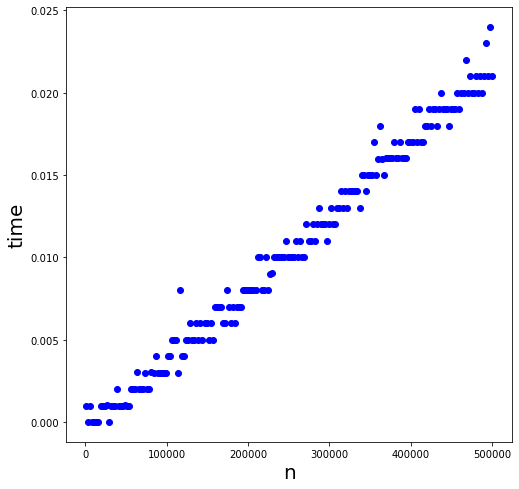

In [59]:
# Add other values for N
# START OF YOUR CODE:
N = np.linspace(1000,500000,200).astype(int)
# END OF YOUR CODE

X_n = []
y_n = []

for i in N:
    X_n.append(i)
    X, y = get_housing_prices_data(N=i, verbose=False)
    init = time.time()

    w = normal_equation_weights(X, y)
    prediction = normal_equation_prediction(X,w)

    init = time.time() - init
    y_n.append(init)
    # print("Execution time = {:.8f}(s)\n".format(init))


plot_points_regression(X_n,
                       y_n,
                       title='Execution time x n',
                       xlabel="n",
                       ylabel='time')

### ↑↑↑ Looking at the graph, what do these steps represent?

In the interval from N=1000 to N=500000 we could see more de 20 steps.
There are some superposition between then.
We can see a linear scaling

hypothesis: the size of N determines should fit in some matrix multiplication instruction constraints. Some SIMD constraint. Some memory hierarchy constraint.

500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000


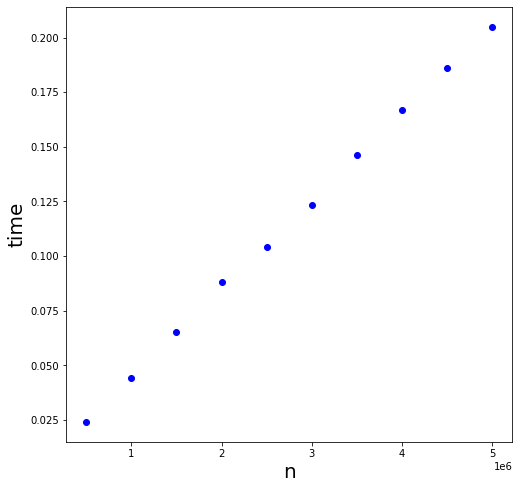

In [70]:
# Add other values for N
# START OF YOUR CODE:
N = np.linspace(500000, 5000000, 10).astype(int)
# END OF YOUR CODE

X_n = []
y_n = []

for i in N:
    print(str(i))
    X_n.append(i)
    X, y = get_housing_prices_data(N=i, verbose=False)
    init = time.time()

    w = normal_equation_weights(X, y)
    prediction = normal_equation_prediction(X,w)

    init = time.time() - init
    y_n.append(init)
    # print("Execution time = {:.8f}(s)\n".format(init))


plot_points_regression(X_n,
                       y_n,
                       title='Execution time x n',
                       xlabel="n",
                       ylabel='time')

↑↑↑ The growth still seem to be linear in the interval from N=500000 to N=5000000.

5000000
5111111
5222222
5333333
5444444
5555555
5666666
5777777
5888888
6000000


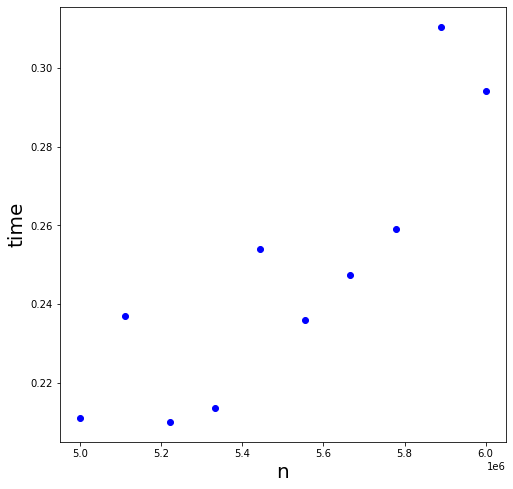

In [71]:
# Add other values for N
# START OF YOUR CODE:
N = np.linspace(5000000, 6000000, 10).astype(int)
# END OF YOUR CODE

X_n = []
y_n = []

for i in N:
    print(str(i))
    X_n.append(i)
    X, y = get_housing_prices_data(N=i, verbose=False)
    init = time.time()

    w = normal_equation_weights(X, y)
    prediction = normal_equation_prediction(X,w)

    init = time.time() - init
    y_n.append(init)
    # print("Execution time = {:.8f}(s)\n".format(init))


plot_points_regression(X_n,
                       y_n,
                       title='Execution time x n',
                       xlabel="n",
                       ylabel='time')

↑↑↑ The growth seems to be more like an exponential function when N > 5222222. I would need more points to be sure, but I have just lost my interest in waiting for the computer to end the bit crunching :-)

# <mark>Exercise 2</mark>

In this exercise, the goal is to play with the data we have collected in our first class. Download the data file from [here](https://edisciplinas.usp.br/draftfile.php/5062945/user/draft/622707057/dataMAC0460_5832.csv) (or directly from e-disciplinas, seção Tarefas). 
We will also try to explore cases where $d>1$.

Note that there might be some invalid data entries. It is up to you how you will handle those data. Note that if you decide to do some pre-processing of the dataset, it should be done in this notebook (you are not allowed to edit the CSV datasheet). Feel free to added new cells if that helps to better organize your code.


## Reading the dataset

In [6]:
import pandas as pd

# load the dataset
df = pd.read_csv('dataMAC0460_5832.csv')
df.head()

,Sex,Age,Height,Weight,Shoe number,Trouser number
0,Female,53,154,59,36,40
1,Male,23,170,56,40,38
2,Female,23,167,63,37,40
3,Male,21,178,78,40,40
4,Female,25,153,58,36,38


In [73]:
df.describe()

,Age,Height,Weight,Shoe number
count,202.000000,202.000000,202.000000,202.000000
mean,28.133663,171.084158,72.004950,39.777228
std,11.934604,12.808496,17.093392,2.857281
min,3.000000,65.000000,15.000000,24.000000
25%,21.000000,166.250000,61.000000,38.000000
50%,23.000000,172.500000,70.000000,40.000000
75%,29.750000,178.000000,81.750000,42.000000
max,67.000000,194.000000,159.000000,46.000000


### Let's establish 'Weight' as the target variable

In [76]:
# Our target variable is the Weight
y = df['Weight']
y

0      59
1      56
2      63
3      78
4      58
       ..
197    57
198    68
199    65
200    51
201    62
Name: Weight, Length: 202, dtype: int64

## <mark>2.1. One feature ($d=1$)</mark>

We will use 'Height' as the input feature and predict the weight

In [74]:
feature_cols = ['Height']
X = df.loc[:, feature_cols]
X.shape

(202, 1)

Will try to visualize the relationship between X and Y

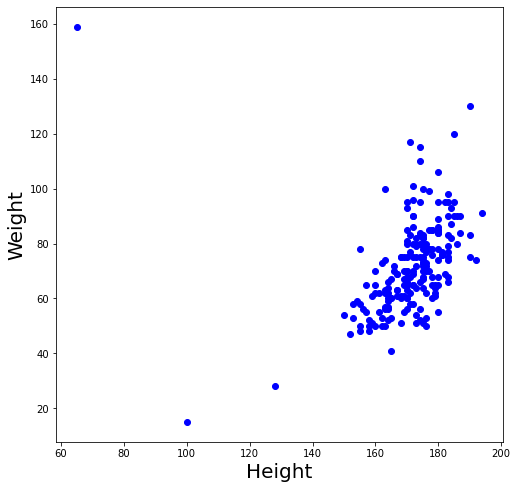

In [78]:
plot_points_regression(X,
                       y,
                       title='Execution time x n',
                       xlabel="Height",
                       ylabel='Weight')

The first points seems to be an error in dataset. I will try to remove samples where $Height < 140$.

This removed 3 outliers/errors.

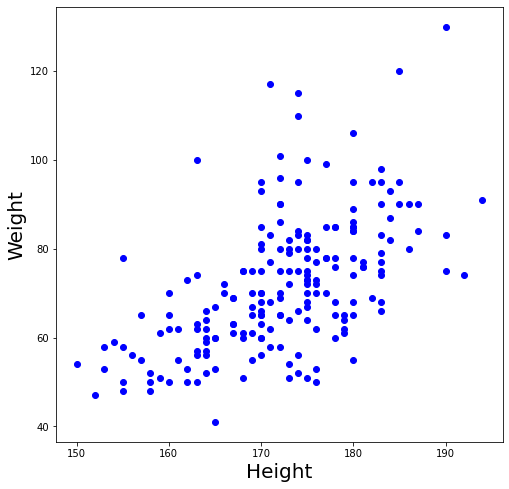

In [8]:
df = df[df.Height > 140]
feature_cols = ['Height']
X = df.loc[:, feature_cols]
y = df['Weight']

plot_points_regression(X,
                       y,
                       title='X and Y relationship',
                       xlabel="Height",
                       ylabel='Weight')

Write the code for computing the following
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute the $R^2$ value
- plot the regression graph (use appropriate values for the parameters of function <tt>plot_points_regression()</tt>)

Estimated w =
 [-101.1603005     1.00606723]
Shape: (2,)


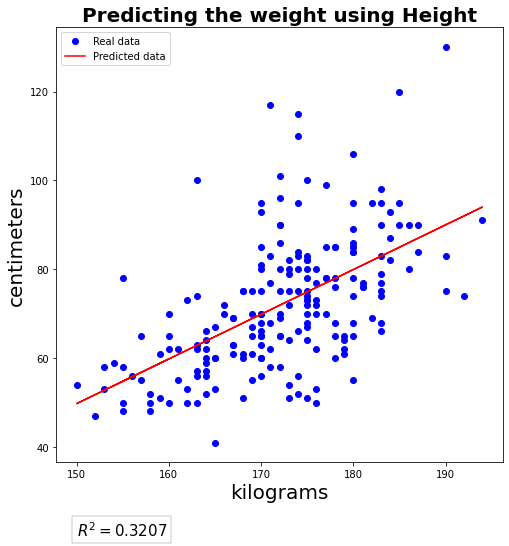

In [9]:
# START OF YOUR CODE:
w = normal_equation_weights(X, y)
print("Estimated w =\n", w)
print("Shape:", w.shape)

prediction = normal_equation_prediction(X, w)

r_2 = r2_score(y_true=y, y_pred=prediction)
mse = mean_squared_error(y_true=y.T, y_pred=prediction.T)

plot_points_regression(X,
                       y,
                       title='Predicting the weight using Height',
                       xlabel="kilograms",
                       ylabel='centimeters',
                       prediction=prediction,
                       legend=True,
                       r_squared=r_2,
                       position=(150, 20))
# END OF YOUR CODE


$R^2$ score of $0.3207$ means that approximately $32\%$ of observed variation can be explained by the model. Not so good.😞


## <mark>2.2 - Two input features ($d=2$)</mark>

Now repeat the exercise using as input the features 'Height' and 'Shoe number'


Before I will try visualize Shoe number values in a plot to look for errors in dataset

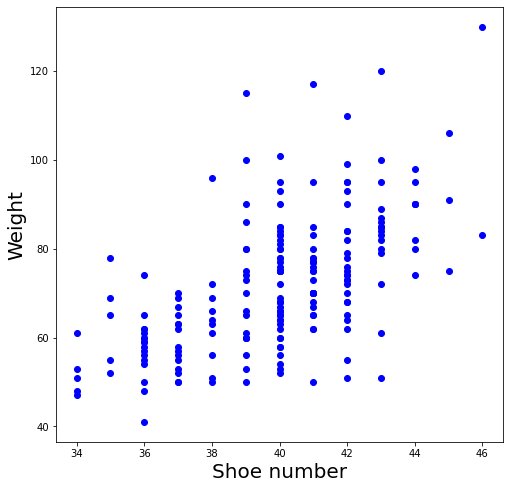

In [102]:
plot_points_regression(df['Shoe number'],
                       y,
                       title='Execution time x n',
                       xlabel="Shoe number",
                       ylabel='Weight')

↑↑↑ I cannot seet any evident error or outsider in $\text{Shoe number}$ feature.

Now I will:
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

Note that our plotting function can not be used for this dataset. Here tehre is no need to do the plotting.

In [20]:
# START OF YOUR CODE:
feature_cols = ['Height', 'Shoe number']
X = df.loc[:, feature_cols]
y = df['Weight']

w = normal_equation_weights(X, y)
print("Estimated w =\n", w)
print("Shape:", w.shape)

prediction = normal_equation_prediction(X, w)

r_2 = r2_score(y_true=y, y_pred=prediction)

print('R2 =', str(r_2))

# END OF YOUR CODE


Estimated w =
 [-93.12466267   0.43372922   2.26802346]
Shape: (3,)
R2 = 0.36557334808620356


Using *Height* and *Shoe number* improved a little the baseline. From $R^2 = 32\%$ to $R^2 = 36\%$. Not very promissing.😞


## 2.3 - <mark>Three input features ($d=3$)</mark>

Now try with three features. There is no need to do plotting here.
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

Which feature should I use? The options are **sex**, **age** and **trouser number**.

**Age** plot shows a lot of points of students with more than 50 years. I cannot remember seeing anyone with more than 50 years in classroom. This data seems to be a little unreliable.

**Trouser number** plot shows something as linear relation between it and the student weight. Seems to be a good candidate for the task.

**Sex** need an converstion from categorical column to an 0-1 column. Created **is_male** feature and the plot shows a certain relationship with Weight variable.

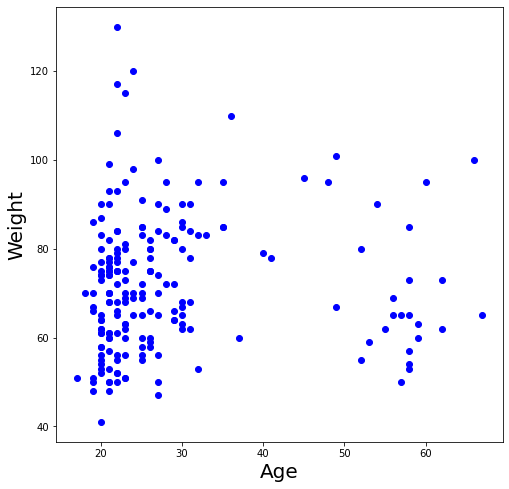

In [108]:
plot_points_regression(df['Age'],
                       y,
                       title='Relationship between X and Y',
                       xlabel="Age",
                       ylabel='Weight')



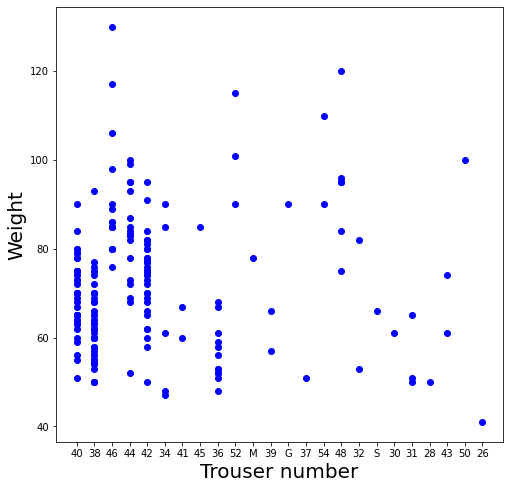

In [111]:
plot_points_regression(df['Trouser number'],
                       y,
                       title='Relationship between X and Y',
                       xlabel="Trouser number",
                       ylabel='Weight')

In [112]:
df.dtypes

Sex               object
Age                int64
Height             int64
Weight             int64
Shoe number        int64
Trouser number    object
dtype: object

**Trouser number** column was loaded as an object because it has mixed numbers and strings values.

I will convert the S, M and G values according the table in this link [link](https://br.privalia.com/microsites/sizeguide)

C:\Users\Diogo\AppData\Local\Temp\ipykernel_16392\1876969449.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trouser number'] = df['Trouser number'].map(clean_trouser_number)


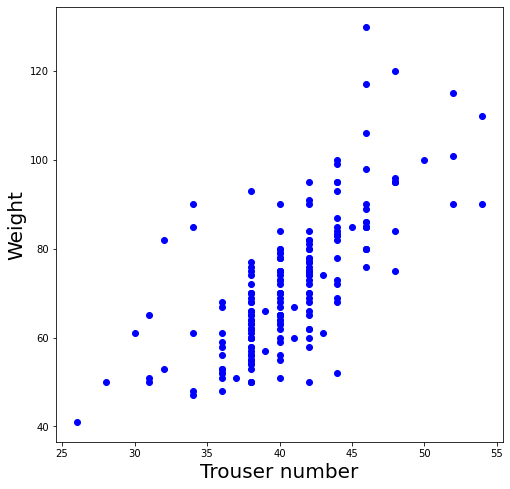

In [117]:
def clean_trouser_number(cell):
    if cell == 'S':
        return 38
    elif cell == 'M':
        return 40
    elif cell == 'G':
        return 42
    else:
        return int(cell)

df['Trouser number'] = df['Trouser number'].map(clean_trouser_number)

plot_points_regression(df['Trouser number'],
                       y,
                       title='Relationship between X and Y',
                       xlabel="Trouser number",
                       ylabel='Weight')

Now I will convert categorical **Sex** column to **is_male** and **is_female** columns.

In [123]:
df['Sex'].unique()

array(['Female', 'Male'], dtype=object)

In [130]:
def generate_is_male_female_columns(row):
    if row['Sex'] == 'Female':
        row['is_male'] = 0
        row['is_female'] = 1
    else:
        row['is_male'] = 1
        row['is_female'] = 0
    return row

df = df.apply(generate_is_male_female_columns, axis=1)



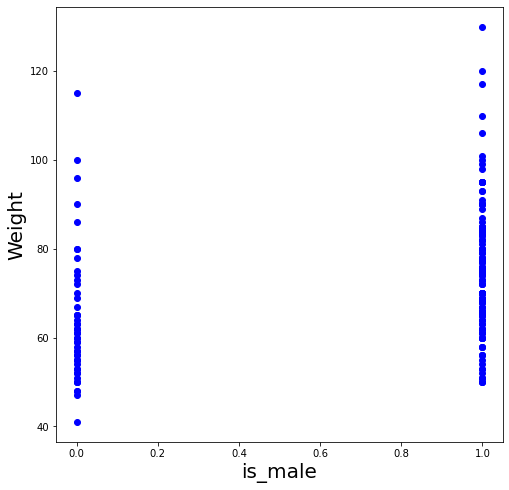

In [131]:
plot_points_regression(df['is_male'],
                       y,
                       title='Relationship between X and Y',
                       xlabel="is_male",
                       ylabel='Weight')

Now try with three features. There is no need to do plotting here.
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

In [132]:
# START OF YOUR CODE:
feature_cols = ['Height', 'Shoe number', 'Trouser number']
X = df.loc[:, feature_cols]
y = df['Weight']

w = normal_equation_weights(X, y)
print("Estimated w =\n", w)
print("Shape:", w.shape)

prediction = normal_equation_prediction(X, w)

r_2 = r2_score(y_true=y, y_pred=prediction)

print('R2 =', str(r_2))
# END OF YOUR CODE


Estimated w =
 [-114.23203186    0.43528156    0.78007192    1.97311647]
Shape: (4,)
R2 = 0.6150222722767842


Using **Height**,  **Shoe number** and **Trouser number** improved the baseline. From $R^2 = 32\%$ to $R^2 = 61\%$. Good.


<hr>

## <mark>2.9 - Experiments </mark>

I would like to test some ideas before writing comments.

### 1. Try to use all available features.

Result: Using all five features showed no significant improvement.



In [137]:
feature_cols = ['Height', 'Shoe number', 'Trouser number', 'is_male', 'is_female', 'Age']
X = df.loc[:, feature_cols]
y = df['Weight']

w = normal_equation_weights(X, y)
print("Estimated w =\n", w)
print("Shape:", w.shape)

prediction = normal_equation_prediction(X, w)

r_2 = r2_score(y_true=y, y_pred=prediction)

print('R2 =', str(r_2))

Estimated w =
 [-8.06442948e+01  4.35080501e-01  9.92575320e-01  1.92498207e+00
 -4.09483197e+01 -3.96959750e+01  1.93994248e-02]
Shape: (7,)
R2 = 0.6157821587529533


### 2. Trying to generate new features.

The idea is to generate features using **genPowerset** util function. 
Function **genPowerset** returns a list that contains all possible combinations of the elements of the input parameter.

```
(Ex)
genPowerset(['a', 'b', 'c'])
returns  [[], ['c'], ['b'], ['b', 'c'], ['a'], ['a', 'c'], ['a', 'b'], ['a', 'b', 'c']]
```

I used the five features as input in this test  ['Height', 'Shoe number', 'Trouser number', 'is_male', 'is_female', 'Age'].


### Results

Table below sumarizes $R^2$ and the time spent in each computation step.

| New features                                      	| $R^2$  	| # Generated features 	| Unique features 	| Time generating features 	| Time calculating normal equation weights 	| Time to predicted data 	| Time calculating $R^2$ 	|
|---------------------------------------------------	|--------	|----------------------	|-----------------	|--------------------------	|------------------------------------------	|------------------------	|------------------------	|
| linear polynomials $(a, b, ab)$                   	| 65,34% 	| 31                   	| 31              	| 0.065s                   	| 0.003s                                   	| 0.0s                   	| 0.0s                   	|
| quadratic polynomials $(a^2, b^2, ab, a^2*b ...)$ 	| 68,56% 	| 1023                 	| 242             	| 0.865s                   	| 0.032s                                   	| 0.0s                   	| 0.0s                   	|
| adding 5 degree polynomials for Height feature    	| 96,86% 	| 65535                	| 895             	| 2.775s                   	| 0.603s                                   	| 0.001s                 	| 0.0s                   	|

### Some points
1. Processing time is dominated by the generation the features and not by calculation of weights.
2. We can see the time spent during weights calculation increasing. But as the number of dataset samples is small (<200), this not represent a problem.
3. We can see thee $R^2$ score gain following the number of generated features.


In [20]:
import math

def getBinaryRep(n, numDigits):
    """ Assumes n and numDigits are non-negatives ints
        Returns a str of length numDigits that is a binary
        representation of n """
    result = ''
    while n > 0:
        result = str(n % 2) + result
        n = n // 2
    if len(result) > numDigits:
        raise ValueError('not enough digits')
    for i in range(numDigits - len(result)):
        result = '0' + result
    return result

def genPowerset(L):
    """ Assumes L is a list
        Returns a list of list that contains all possible
        combinations of the elements of L. E.g., if
        L is [1, 2] it wil return a list with elements
        [], [1], [2], and [1,2]. """
    powerset = []
    for i in range(0, 2**len(L)):
        binStr = getBinaryRep(i, len(L))
        subset = []
        for j in range(len(L)):
            if binStr[j] == '1':
                subset.append(L[j])
        powerset.append(subset)
    return powerset

def generate_is_male_female_columns(row):
    if row['Sex'] == 'Female':
        row['is_male'] = 0
        row['is_female'] = 1
    else:
        row['is_male'] = 1
        row['is_female'] = 0
    return row

def clean_trouser_number(cell):
    if cell == 'S':
        return 38
    elif cell == 'M':
        return 40
    elif cell == 'G':
        return 42
    else:
        return int(cell)


def cleaned_dataset():
    # Load 
    dataframe = pd.read_csv('dataMAC0460_5832.csv')

    # Remove 3 samples 
    dataframe = dataframe[dataframe.Height > 140]

    # Clean Trouser number
    dataframe['Trouser number'] = dataframe['Trouser number'].map(clean_trouser_number)
    
    # Generate 0-1 columns for Sex categorical columns
    dataframe = dataframe.apply(generate_is_male_female_columns, axis=1)

    feature_cols = ['Height', 'Shoe number', 'Trouser number', 'is_male', 'Age']
    X = dataframe.loc[:, feature_cols]
    y = dataframe['Weight']

    return (X, y)


def generate_new_features(dataframe, new_features_ideas, verbose=True):
    init = time.time()
    _, *new_features_ideas = new_features_ideas #trick to remove the first empty generated set

    already_done = []

    for feature_combination in new_features_ideas:
        feature_name = ' * '.join(feature_combination)
        if feature_name not in already_done:
            already_done.append(feature_name)
            values = dataframe[feature_combination]
            combination = values.product(axis=1)
            dataframe[feature_name] = combination
    init = time.time() - init

    if verbose == True:
        print('\--> generated', str(len(new_features_ideas)), 'features of these ', str(dataframe.shape[1]) ,'are unique. In', str(init), 'seconds.' )




new_features_ideas_to_test = [
    {'name': 'linear polynomials features', 'set': genPowerset(['Height', 'Shoe number', 'Trouser number', 'is_male', 'Age'])},
    {'name': 'quadratic polynomials features', 'set': genPowerset(['Height', 'Height', 'Shoe number', 'Shoe number', 'Trouser number', 'Trouser number', 'is_male', 'is_male', 'Age', 'Age'])},
    {'name': 'adding polynomial of 5h degree for Height feature', 'set': genPowerset(['Height', 'Height', 'Height', 'Height','Height', 'Height','Shoe number', 'Shoe number', 'Shoe number', 'Trouser number', 'Trouser number', 'Trouser number', 'is_male', 'Age', 'Age', 'Age'])}
]


for new_features_ideas in new_features_ideas_to_test:
    print(new_features_ideas['name'])    
    (X, y) = cleaned_dataset()
    generate_new_features(X, new_features_ideas['set'])
    time_normal_equation_weights = time.time()
    w = normal_equation_weights(X, y)
    time_normal_equation_weights = time.time() - time_normal_equation_weights
    time_prediction = time.time()
    prediction = normal_equation_prediction(X, w)
    time_prediction = time.time() - time_prediction
    time_r2 = time.time()
    r_2 = r2_score(y_true=y, y_pred=prediction)
    time_r2 = time.time() - time_r2
    print('\--> normal_equation_weights in ', str(time_normal_equation_weights),'seconds')
    print('\--> time_prediction in ', str(time_prediction),'seconds')
    print('\--> R2 =', str(r_2),'in ', str(time_r2),'seconds\n')


# generate_new_features(X)
# w = normal_equation_weights(X, y)
# prediction = normal_equation_prediction(X, w)
# r_2 = r2_score(y_true=y, y_pred=prediction)

# print('R2 =', str(r_2))


linear polynomials features
\--> generated 31 features of these  31 are unique. In 0.05800199508666992 seconds.
\--> normal_equation_weights in  0.002001523971557617 seconds
\--> time_prediction in  0.0 seconds
\--> R2 = 0.653435384842756 in  0.0010006427764892578 seconds

quadratic polynomials features
\--> generated 1023 features of these  242 are unique. In 0.41499948501586914 seconds.
\--> normal_equation_weights in  0.03200101852416992 seconds
\--> time_prediction in  0.0 seconds
\--> R2 = 0.6856262885110491 in  0.0 seconds

adding polynomial of 5h degree for Height feature
\--> generated 65535 features of these  895 are unique. In 2.642000436782837 seconds.
\--> normal_equation_weights in  0.5766305923461914 seconds
\--> time_prediction in  0.0010008811950683594 seconds
\--> R2 = 0.9686250309721967 in  0.0010020732879638672 seconds



### 3. Split dataset in train and test set and evaluated if it is overfiting

Implemented kfold test spliting strategy. (k=5)

### Results

| New features                                      	| Unique features 	| $R^2	ext{train}$ 	| $R^2	ext{test}$ 	|
|---------------------------------------------------	|-----------------	|-------------------	|------------------	|
| linear polynomials features  | 31  |  66.57% | 48.76% | 
| quadratic polynomials features  | 242  |  70.47% | 28.50% | 
| adding polynomial of 5h degree for Height feature  | 895  |  99.39% | -2963.49% | 
| Age  | 1  |  0.48% | -3.01% | 
| is_male  | 1  |  9.28% | 8.98% | 
| is_male,Age  | 2  |  11.60% | 8.67% | 
| Trouser number  | 1  |  49.83% | 50.63% | 
| Trouser number,Age  | 2  |  50.46% | 51.45% | 
| Trouser number,is_male  | 2  |  54.17% | 55.40% | 
| Trouser number,is_male,Age  | 3  |  54.26% | 54.95% | 
| Shoe number  | 1  |  34.62% | 31.84% | 
| Shoe number,Age  | 2  |  38.46% | 31.77% | 
| Shoe number,is_male  | 2  |  39.11% | 32.34% | 
| Shoe number,is_male,Age  | 3  |  41.66% | 32.24% | 
| Shoe number,Trouser number  | 2  |  58.84% | 59.45% | 
| Shoe number,Trouser number,Age  | 3  |  59.07% | 58.37% | 
| Shoe number,Trouser number,is_male  | 3  |  59.08% | 58.89% | 
| Shoe number,Trouser number,is_male,Age  | 4  |  59.30% | 57.76% | 
| Height  | 1  |  30.90% | 31.19% | 
| Height,Age  | 2  |  34.32% | 32.46% | 
| Height,is_male  | 2  |  31.32% | 29.95% | 
| Height,is_male,Age  | 3  |  34.47% | 31.62% | 
| Height,Trouser number  | 2  |  59.95% | 60.92% | 
| Height,Trouser number,Age  | 3  |  60.08% | 60.40% | 
| Height,Trouser number,is_male  | 3  |  60.02% | 60.71% | 
| Height,Trouser number,is_male,Age  | 4  |  60.20% | 60.11% | 
| Height,Shoe number  | 2  |  35.95% | 34.29% | 
| Height,Shoe number,Age  | 3  |  40.08% | 34.95% | 
| Height,Shoe number,is_male  | 3  |  40.41% | 33.69% | 
| Height,Shoe number,is_male,Age  | 4  |  43.18% | 34.41% | 
| Height,Shoe number,Trouser number  | 3  |  60.49% | 61.26% | 
| Height,Shoe number,Trouser number,Age  | 4  |  60.75% | 60.40% | 
| Height,Shoe number,Trouser number,is_male  | 4  |  60.72% | 60.44% | 
| Height,Shoe number,Trouser number,is_male,Age  | 5  |  60.97% | 59.57% | 

### Some points

- First and second lines are in high bias and high variance(overfit) regimen.
- Third line is high variance(overfit) regimen.
- The best result still the simple case using Height,Shoe number,Trouser number features. R2test $60.49\%$, R2train $61.26\%$.

In [22]:
from statistics import mean

def train_test_split(X, y, test_size=0.33, seed=0):
    dataset = X.merge(y, left_index=True, right_index=True)
    np.random.seed(seed)
    m = X.shape[0]
    test_size = int(m // (1/test_size))
    train_size = int(m - test_size)

    #Step 1: Sample dataset
    dataset_shuffled = dataset.sample(n=m, ignore_index=True, random_state=seed)

    #Step 2: Split train and test
    train = dataset_shuffled.head(n=train_size)
    test = dataset_shuffled.tail(n=test_size)

    #Step 3: Split X and y
    train_X = train.iloc[:,:-1]
    train_y = train.iloc[:,-1:]
    test_X = test.iloc[:,:-1]
    test_y = test.iloc[:,-1:]

    return (train_X, train_y, test_X, test_y)

def kfold_split(X, y, test_size=0.33, k=5, seed=0):
    splits = []
    for iteration in range(k):
        splits.append( train_test_split(X, y, test_size=test_size, seed=(seed+iteration)) )
    return splits

def calculate_train_test_r2(X, y):
    splits = kfold_split(X, y)
    train_r2_results = []
    test_r2_results  = []

    for (train_X, train_y, test_X, test_y) in splits:
        w = normal_equation_weights(train_X, train_y)
        train_prediction = normal_equation_prediction(train_X, w)
        test_prediction  = normal_equation_prediction(test_X, w)
        train_r2 = r2_score(y_true=train_y, y_pred=train_prediction)
        test_r2  = r2_score(y_true=test_y, y_pred=test_prediction)
        train_r2_results.append(train_r2)
        test_r2_results.append(test_r2)

    train_r2_avg = mean(train_r2_results) * 100
    test_r2_avg = mean(test_r2_results) * 100
    # print('|',  adding 5 degree polynomials for Height feature    	| 895             	| 99,39%            	| -29.63%          	|)
    print(f" {train_r2_avg:.2f}% | {test_r2_avg:.2f}% | ")


def generate_some_features_to_evaluate():
    features_set_to_evaluate = [
        {'name': 'linear polynomials features', 'set': genPowerset(['Height', 'Shoe number', 'Trouser number', 'is_male', 'Age'])},
        {'name': 'quadratic polynomials features', 'set': genPowerset(['Height', 'Height', 'Shoe number', 'Shoe number', 'Trouser number', 'Trouser number', 'is_male', 'is_male', 'Age', 'Age'])},
        {'name': 'adding polynomial of 5h degree for Height feature', 'set': genPowerset(['Height', 'Height', 'Height', 'Height','Height', 'Height','Shoe number', 'Shoe number', 'Shoe number', 'Trouser number', 'Trouser number', 'Trouser number', 'is_male', 'Age', 'Age', 'Age'])}
    ]
    
    combinations = genPowerset(['Height', 'Shoe number', 'Trouser number', 'is_male', 'Age'])
    _, *combinations = combinations #trick to remove the first empty generated set

    for c in combinations:
        f = {'name': ','.join(c), 'feature_cols': c}
        features_set_to_evaluate.append(f)

    return features_set_to_evaluate

def run():
    header = ''' 
    | New features                                      	| Unique features 	| $R^2\text{train}$ 	| $R^2\text{test}$ 	|
    |---------------------------------------------------	|-----------------	|-------------------	|------------------	|
    '''
    print(header)
    features_set_to_evaluate = generate_some_features_to_evaluate()
    for features in features_set_to_evaluate:
        print('|', features['name'], ' | ', end = '')    

        (X, y) = cleaned_dataset()
        if 'feature_cols' in features:
            feature_cols = features['feature_cols']
            X = X.loc[:, feature_cols]
            print(str(len(feature_cols)), ' | ', end = '')
        else:
            generate_new_features(X, features['set'], verbose=False)
            print(str(X.shape[1]), ' | ', end = '')

        calculate_train_test_r2(X, y)

run()

 
    | New features                                      	| Unique features 	| $R^2	ext{train}$ 	| $R^2	ext{test}$ 	|
    |---------------------------------------------------	|-----------------	|-------------------	|------------------	|
    
| linear polynomials features  | 31  |  66.57% | 48.76% | 
| quadratic polynomials features  | 242  |  70.47% | 28.50% | 
| adding polynomial of 5h degree for Height feature  | 895  |  99.39% | -2963.49% | 
| Age  | 1  |  0.48% | -3.01% | 
| is_male  | 1  |  9.28% | 8.98% | 
| is_male,Age  | 2  |  11.60% | 8.67% | 
| Trouser number  | 1  |  49.83% | 50.63% | 
| Trouser number,Age  | 2  |  50.46% | 51.45% | 
| Trouser number,is_male  | 2  |  54.17% | 55.40% | 
| Trouser number,is_male,Age  | 3  |  54.26% | 54.95% | 
| Shoe number  | 1  |  34.62% | 31.84% | 
| Shoe number,Age  | 2  |  38.46% | 31.77% | 
| Shoe number,is_male  | 2  |  39.11% | 32.34% | 
| Shoe number,is_male,Age  | 3  |  41.66% | 32.24% | 
| Shoe number,Trouser number  | 2  |  58.84%

### 4. Last try. I will add regularization.

I will try to add the regularizaiton term.

 $\text{weights} = (X^T X + \lambda . L)^{-1}X^T y$


 ### Results

 | New features                                      	| Unique features 	| $R^2\text{train}$ 	| $R^2\text{test}$ 	| best $\lambda$ found 	| $R^2\text{train}$ with regularization 	| $R^2\text{test}$ with regularization 	|
|---------------------------------------------------	|-----------------	|-------------------	|------------------	|----------------------	|---------------------------------------	|--------------------------------------	|
| linear polynomials $(a, b, ab)$                   	| 31              	| 66,56%            	| 48.76%           	| $10^8$               	| 62,17%                                	| 58,93%                               	|
| quadratic polynomials $(a^2, b^2, ab, a^2*b ...)$ 	| 242             	| 70,47%            	| 28.50%           	| $10^{19}$              	| 68,05%                                	| 49,98%                               	|
| adding 5 degree polynomials for Height feature    	| 895             	| 99,39%            	| -29.63%          	| $10^{38}$              	| 89,93%                                	| -3,46%                              	|


### Some points

- Regularization helped a little in first line. I think this was my best model. At the end I cannot improve the simple case of using only Height,Shoe number,Trouser number features which have R2test $60.49\%$, R2train $61.26\%$. 
- Regularization improved a little the second line.
- Regularization could not help the third line.

In [164]:
def normal_equation_weights_with_regularization(X, y, lambd=0):
    """
    Calculates the weights of a linear function using the normal equation method WITH REGULARIZATION TERM.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param y: regression targets
    :type lambd: float
    :param lambd: regularization factor
    
    :type y: np.ndarray(shape=(N, 1))    
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d, 1))
    """
    
    # START OF YOUR CODE:
    m = X.shape[0]
    n = X.shape[1]
    L = np.row_stack( [ np.zeros((1, n+1)), np.column_stack([ np.zeros((n,1)), np.eye(n,n)])]) # we dont regularize the bias term
    X = np.column_stack( [np.ones((m,1)), X ]) # adds the bias term in X
    weights = np.dot( np.dot( np.linalg.pinv( np.dot(X.T, X) + np.multiply(lambd, L) ), X.T), y) # normal method
    return weights
    # END OF YOUR CODE


def calculate_train_test_r2_with_regularization(X, y, lambd=0):
    splits = kfold_split(X, y)
    train_r2_results = []
    test_r2_results  = []

    for (train_X, train_y, test_X, test_y) in splits:
        w = normal_equation_weights_with_regularization(train_X, train_y, lambd=lambd)
        train_prediction = normal_equation_prediction(train_X, w)
        test_prediction  = normal_equation_prediction(test_X, w)
        train_r2 = r2_score(y_true=train_y, y_pred=train_prediction)
        test_r2  = r2_score(y_true=test_y, y_pred=test_prediction)
        train_r2_results.append(train_r2)
        test_r2_results.append(test_r2)

    train_r2_avg = mean(train_r2_results)
    test_r2_avg = mean(test_r2_results)
    print('\--> lambda =', str(lambd), ', R2(train) =', str(train_r2_avg), '  | R2(test) =', str(test_r2_avg))


features_set_to_evaluate = [
    {'name': 'linear polynomials features', 'set': genPowerset(['Height', 'Shoe number', 'Trouser number', 'is_male', 'Age'])},
    {'name': 'quadratic polynomials features', 'set': genPowerset(['Height', 'Height', 'Shoe number', 'Shoe number', 'Trouser number', 'Trouser number', 'is_male', 'is_male', 'Age', 'Age'])},
    {'name': 'adding polynomial of 5h degree for Height feature', 'set': genPowerset(['Height', 'Height', 'Height', 'Height','Height', 'Height','Shoe number', 'Shoe number', 'Shoe number', 'Trouser number', 'Trouser number', 'Trouser number', 'is_male', 'Age', 'Age', 'Age'])}
]

lambdas_to_evaluate = [0, 1e8, 1e19, 1e38]


for features in features_set_to_evaluate:
    print(features['name'])    
    (X, y) = cleaned_dataset()
    generate_new_features(X, features['set'])

    for lambd in lambdas_to_evaluate:
        calculate_train_test_r2_with_regularization(X, y, lambd=lambd)
    
    print('\n')

linear polynomials features
\--> generated 31 features of these  31 are unique. In 0.06299853324890137 seconds.
\--> lambda = 0 , R2(train) = 0.6656801595705047   | R2(test) = 0.4876073917683773
\--> lambda = 100000000.0 , R2(train) = 0.6217991265683201   | R2(test) = 0.5893516300689341
\--> lambda = 1e+19 , R2(train) = -22.246677335650336   | R2(test) = -23.410382032442683
\--> lambda = 1e+38 , R2(train) = -22.310428572583128   | R2(test) = -23.479645518984086


quadratic polynomials features
\--> generated 1023 features of these  242 are unique. In 0.4289987087249756 seconds.
\--> lambda = 0 , R2(train) = 0.7047066934692578   | R2(test) = 0.2850072396718911
\--> lambda = 100000000.0 , R2(train) = 0.7047066932144884   | R2(test) = 0.28500727860061853
\--> lambda = 1e+19 , R2(train) = 0.6805500038297095   | R2(test) = 0.4998063700668235
\--> lambda = 1e+38 , R2(train) = -22.310427769328136   | R2(test) = -23.4796445866831


adding polynomial of 5h degree for Height feature
\--> generat

# 3. <mark>Your comments</mark>

Write any comments about your implementation or about the results you observed.

===>


### Part 1
- Added a random seed parameter to try to make data sampling more deterministic in get_housing_prices_data function and other data sampling functions.
- Normal equation method seems to be very suitable for this small dataset. Small number of samples and features.
- I enjoyed implementing some auxiliary functions. I think this help me getting a better sense about what I am doing. (my_r2_score, my_mean_squared_error, train_test_split, kfold_test_split,....) It also helped me learning more about numpy and pandas methods.
- Now, make more sense to me the reason why we are using R2_score. The denominator part of it formula acts as kind of standarization. This seems to make this metric more suitable when we need to compare models.
- When experimenting with processing time, I saw that processing time increases as N increases (No news hera). 
- After ploting some graphs I found some strange behavior. The plot looked like a stairstep function(?função degrau?). 
- May be, this is caused by some matrix multiplication optimizaiton constraints, mixed with some SIMD constraints and mixed with some memory hierarchy constraints.
- Also I could see that when N > 5222222 the growth seems to be more like an exponential function. I would need more points to be sure, but I have just lost my interest in waiting for the computer to end processing.

### Part 2
- I could spot strange values of $Heights$ column in datase. Removed 3 points because I think they could negative affect our regression model.
- Also, I could see that some features do not help much(Shoe number, Age) and others seem to be very significant (Height and Trouser number).
- After standard EP questions I tried to improve the model generating new features. At this point I could see a very good improvement in R2 metric.
- Aiming to evaluate an overfit problem I started to split dataset in train and test sets.
- I concluded that all models that I proposed are in overft regimen.
- Implemented the normal method with the regularization term. This helped a little but was not enough to end with a good model.
- At the end I think we could improve the model iterating in two parts: Improving the model or getting more data.
- In model part, my next trials would be training a SVM or a RandomForest models.
- In data part, I think we could iterate to get more samples to improve the overfiting situation.






